## Типология языка

* **Древнегреческий**: Индоевропейская семья -> Палеобалканская ветвь -> Греческая группа; синтетический, флективный по морфологии: грамматическое значение выражается внутри слова - окончания, *общая характеристика греческого предложения: свободный порядок слов, частая эллипсность, наличие частиц-коннекторов в начале предложения.*
* **Норвежский**: Индоевропейская семья -> Германская ветвь -> Скандинавская группа -> Континентальная подгруппа; флективный по морфологии; развитие аналитизма; порядок слов фиксирован, но место глагола может меняться

In [1]:
import conllu
from statistics import mean, median
from collections import Counter
import numpy as np
import operator

In [2]:
from io import open
from conllu import parse_incr, parse

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

C:\programs\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from tqdm import tqdm_notebook as tqdm

In [5]:
import matplotlib.pyplot as plt

In [6]:
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM, SimpleRNN, Bidirectional, GRU, TimeDistributed
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

Читаем и парсим conllu файлы для каждого языка:

In [7]:
data_file = open("UD_Ancient_Greek-Perseus/grc_perseus-ud-train.conllu", "r", encoding="utf-8")
greek = list(parse_incr(data_file))

data_file_test = open("UD_Ancient_Greek-Perseus/grc_perseus-ud-test.conllu", "r", encoding="utf-8")
greek_test = list(parse_incr(data_file_test))

In [8]:
data_file = open("UD_Norwegian-Bokmaal/no_bokmaal-ud-train.conllu", "r", encoding="utf-8")
norv = list(parse_incr(data_file))

data_file_test = open("UD_Norwegian-Bokmaal/no_bokmaal-ud-test.conllu", "r", encoding="utf-8")
norv_test = list(parse_incr(data_file_test))

Посчитаем статистику:

In [9]:
def stats(lang):
    len_sent = len(lang) #количество предложений
    words = Counter() #подсчет слов (уникальных)
    pos_tags = Counter() #подсчет тегов
    for sent in lang:
        for word in sent:
            words[word['form']]+=1 #
            pos_tags[word['upostag']]+=1
    #words = set([word['form'] for sent in lang for word in sent])
    #pos_tags = len(set([meta['upostag'] for sent in lang for meta in sent]))
    sents = [len(sent) for sent in lang] #длина каждого предложения
    max_w = max(sents) #длина максимального предложения
    min_w = min(sents) #длина минимального предложения
    mean_w = mean(sents) #средняя длина предложения
    median_w = median(sents) #медиана
    return {'len_sent':len_sent, 'words':words, 'pos_tags':pos_tags, 'max':max_w, 'min':min_w, 'mean':mean_w, 'median':median_w, 'sents': sents}

In [10]:
stats_train_g = stats(greek)
stats_test_g = stats(greek_test)

stats_train_n = stats(norv)
stats_test_n = stats(norv_test)


In [11]:
print("For Ancient Greek Train:\n\tSentences: {0}\n\tWords: {1}\n\tPOS-tags: {2}\n\tWords Max: {3}\n\tWords Min: {4}\n\tWords Mean: {5}\n\tWords Median: {6}".format(stats_train_g['len_sent'], len(stats_train_g['words']), len(stats_train_g['pos_tags']), stats_train_g['max'], stats_train_g['min'], stats_train_g['mean'], stats_train_g['median']))
print('-'*20)
print("For Ancient Greek Test:\n\tSentences: {0}\n\tWords: {1}\n\tPOS-tags: {2}\n\tWords Max: {3}\n\tWords Min: {4}\n\tWords Mean: {5}\n\tWords Median: {6}".format(stats_test_g['len_sent'], len(stats_test_g['words']), len(stats_test_g['pos_tags']), stats_test_g['max'], stats_test_g['min'], stats_test_g['mean'], stats_test_g['median']))
print('-'*20)
print("For Norvegian Train:\n\tSentences: {0}\n\tWords: {1}\n\tPOS-tags: {2}\n\tWords Max: {3}\n\tWords Min: {4}\n\tWords Mean: {5}\n\tWords Median: {6}".format(stats_train_n['len_sent'], len(stats_train_n['words']), len(stats_train_n['pos_tags']), stats_train_n['max'], stats_train_n['min'], stats_train_n['mean'], stats_train_n['median']))
print('-'*20)
print("For Norvegian Test:\n\tSentences: {0}\n\tWords: {1}\n\tPOS-tags: {2}\n\tWords Max: {3}\n\tWords Min: {4}\n\tWords Mean: {5}\n\tWords Median: {6}".format(stats_test_n['len_sent'], len(stats_test_n['words']), len(stats_test_n['pos_tags']), stats_test_n['max'], stats_test_n['min'], stats_test_n['mean'], stats_test_n['median']))

For Ancient Greek Train:
	Sentences: 11476
	Words: 33237
	POS-tags: 14
	Words Max: 159
	Words Min: 2
	Words Mean: 13.93299058905542
	Words Median: 12.0
--------------------
For Ancient Greek Test:
	Sentences: 1306
	Words: 7314
	POS-tags: 13
	Words Max: 79
	Words Min: 2
	Words Mean: 16.04823889739663
	Words Median: 14.0
--------------------
For Norvegian Train:
	Sentences: 15696
	Words: 30072
	POS-tags: 17
	Words Max: 91
	Words Min: 1
	Words Mean: 15.5381625891947
	Words Median: 14.0
--------------------
For Norvegian Test:
	Sentences: 1939
	Words: 6616
	POS-tags: 17
	Words Max: 66
	Words Min: 1
	Words Mean: 15.45435791645178
	Words Median: 14


Сравним слова в тренировочной и тестовой:

In [12]:
# for greek:
words_test_g = set(stats_test_g['words'].keys())
words_test_g.difference_update(set(stats_train_g['words'].keys()))
print("New words in Ancient Greek Test: {}%".format(round(len(words_test_g)/len(stats_test_g['words'])*100)))

New words in Ancient Greek Test: 63%


In [13]:
# for norvegian:
words_test_n = set(stats_test_n['words'].keys())
words_test_n.difference_update(set(stats_train_n['words'].keys()))
print("New words in Norvegian Test: {}%".format(round(len(words_test_n)/len(stats_test_n['words'])*100)))

New words in Norvegian Test: 37%


Разделим исходные текстовые данные на предложения и тэги, чтобы было удобнее перевести в численные представления:

In [14]:
def separate(data):
    new = []
    for sent in data:
        new.append([(w['form'], w['upostag']) for w in sent])
    sents, tags =[], [] 
    for tagged in new:
        sent, tag = zip(*tagged)
        sents.append(np.array(sent))
        tags.append(np.array(tag))
    return sents,tags

In [15]:
sent_train_g, tag_train_g = separate(greek)
sent_test_g, tag_test_g = separate(greek_test)

sent_train_g[:3], tag_train_g[:3]

([array(['ἐρᾷ', 'μὲν', 'ἁγνὸς', 'οὐρανὸς', 'τρῶσαι', 'χθόνα', ',', 'ἔρως',
         'δὲ', 'γαῖαν', 'λαμβάνει', 'γάμου', 'τυχεῖν', '·'], dtype='<U8'),
  array(['ὄμβρος', 'δ̓', 'ἀπ̓', 'εὐνάοντος', 'οὐρανοῦ', 'πεσὼν', 'ἔκυσε',
         'γαῖαν', '·'], dtype='<U9'),
  array(['ἡ', 'δὲ', 'τίκτεται', 'βροτοῖς', 'μήλων', 'τε', 'βοσκὰς', 'καὶ',
         'βίον', 'Δημήτριον', '·'], dtype='<U9')],
 [array(['VERB', 'ADV', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'PUNCT', 'NOUN',
         'CCONJ', 'NOUN', 'VERB', 'NOUN', 'VERB', 'PUNCT'], dtype='<U5'),
  array(['NOUN', 'ADV', 'ADP', 'ADJ', 'NOUN', 'VERB', 'VERB', 'NOUN',
         'PUNCT'], dtype='<U5'),
  array(['DET', 'ADV', 'VERB', 'NOUN', 'NOUN', 'ADV', 'NOUN', 'CCONJ',
         'NOUN', 'ADJ', 'PUNCT'], dtype='<U5')])

In [16]:
sent_train_n, tag_train_n = separate(norv)
sent_test_n, tag_test_n = separate(norv_test)

sent_train_n[:3], tag_train_n[:3]

([array(['Lam', 'og', 'piggvar', 'på', 'bryllupsmenyen'], dtype='<U14'),
  array(['Kamskjell', ',', 'piggvar', 'og', 'lammefilet', 'sto', 'på',
         'menyen', 'under', 'den', 'kongelige', 'gallamiddagen', '.'],
        dtype='<U13'),
  array(['Og', 'til', 'dessert', ':', 'Parfait', 'à', 'la', 'Mette-Marit',
         '.'], dtype='<U11')],
 [array(['NOUN', 'CCONJ', 'NOUN', 'SCONJ', 'NOUN'], dtype='<U5'),
  array(['NOUN', 'PUNCT', 'NOUN', 'CCONJ', 'NOUN', 'VERB', 'ADP', 'NOUN',
         'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], dtype='<U5'),
  array(['CCONJ', 'ADP', 'NOUN', 'PUNCT', 'PROPN', 'X', 'X', 'PROPN',
         'PUNCT'], dtype='<U5')])

Создадим lookup-таблицу для перевода данных в вектора:

In [17]:
def to_index(stats_train):
    word2index = {w: i + 2 for i, w in enumerate(list(stats_train['words']))}
    word2index['PAD'] = 0
    word2index['OOV'] = 1

    tag2index = {t: i + 2 for i, t in enumerate(list(stats_train['pos_tags']))}
    tag2index['PAD'] = 0
    tag2index['OOV'] = 1
    return word2index, tag2index

In [18]:
word2index_g, tag2index_g = to_index(stats_train_g)
word2index_n, tag2index_n = to_index(stats_train_n)

In [19]:
tag2index_g

{'ADJ': 4,
 'ADP': 8,
 'ADV': 3,
 'CCONJ': 7,
 'DET': 9,
 'INTJ': 12,
 'NOUN': 5,
 'NUM': 13,
 'OOV': 1,
 'PAD': 0,
 'PART': 15,
 'PRON': 10,
 'PUNCT': 6,
 'SCONJ': 11,
 'VERB': 2,
 'X': 14}

Зададим параметры для модели:

Для того, чтобы подобрать MAX_SEQLEN, возьмем такую длину, чтобы количество предложений этой длины составляло хотя бы 1% от всего корпуса (~100-150 предложений). 1% был выведем из расчета на то, в корпусе могут быть тексты художественные (в частности, для древнегреческого - "The treebank contains most of the New Testament plus selections from Herodotus' Histories."(с)Readme из репозитория, то есть состоит из классических текстов, в которых часто могут использоваться длинные предложения). Если брать меньший процент, то максимальная длина сокращается ~до среднего - 10-15, что, на мой взгляд, достаточно короткие предложения

In [20]:
MAX_SEQLEN_g = 0
for i, k in sorted(Counter(stats_train_g['sents']).items()):
    if i<10:
        continue
    if k/len(stats_train_g['sents'])>0.01:
        MAX_SEQLEN_g = i
    else:
        break

In [21]:
MAX_SEQLEN_n = 0
for i, k in sorted(Counter(stats_train_n['sents']).items()):
    if i<10:
        continue
    if k/len(stats_train_n['sents'])>0.01:
        MAX_SEQLEN_n = i
    else:
        break

In [22]:
MAX_SEQLEN_g, MAX_SEQLEN_n

(26, 30)

Интересно, что 1 проценту в греческом соответствуют более короткие предложения, чем в норвежском. Полагаю, это связано с тем, что норвеский больше тяготеет к аналитизму, а греческий - к синтетизму

Определяем остальные параметры. Основные критерии выбора параметров для сети - хорошие результаты, но щадяще для компьютера 

In [23]:
NUM_EPOCHS = 15
EMB_SIZE = 150
HIDDEN_SIZE = 64
BATCH_SIZE = 264

S_MAX_FEATURES_g = len(word2index_g)
T_MAX_FEATURES_g = len(tag2index_g)

S_MAX_FEATURES_n = len(word2index_n)
T_MAX_FEATURES_n = len(tag2index_n)

In [24]:
print("Parameters for Greek: ", MAX_SEQLEN_g, S_MAX_FEATURES_g, T_MAX_FEATURES_g)
print("Parameters for Norvegian: ", MAX_SEQLEN_n, S_MAX_FEATURES_n, T_MAX_FEATURES_n)

Parameters for Greek:  26 33239 16
Parameters for Norvegian:  30 30074 19


Переводим предложения в векторное представление, ссылаясь на lookup, заполняем паддинги. Для out-of-vocabulary слов записываем 1

In [25]:
def to_num(data, lookup):
    nums = []
    for i in data:
        nums.append([lookup.get(w,1) for w in i])
    return nums

In [26]:
def padding(data, MAX_SEQLEN):
    return pad_sequences(data, maxlen=MAX_SEQLEN, padding='post', truncating="post")

In [27]:
s_train_g, t_train_g = to_num(sent_train_g, word2index_g), to_num(tag_train_g, tag2index_g)
s_test_g, t_test_g = to_num(sent_test_g, word2index_g), to_num(tag_test_g, tag2index_g)

X_train_g, Y_train_g, X_test_g, Y_test_g = padding(s_train_g, MAX_SEQLEN_g), padding(t_train_g, MAX_SEQLEN_g), padding(s_test_g, MAX_SEQLEN_g), padding(t_test_g, MAX_SEQLEN_g)

In [28]:
s_train_n, t_train_n = to_num(sent_train_n, word2index_n), to_num(tag_train_n, tag2index_n)
s_test_n, t_test_n = to_num(sent_test_n, word2index_n), to_num(tag_test_n, tag2index_n)

X_train_n, Y_train_n, X_test_n, Y_test_n = padding(s_train_n, MAX_SEQLEN_n), padding(t_train_n, MAX_SEQLEN_n), padding(s_test_n, MAX_SEQLEN_n), padding(t_test_n, MAX_SEQLEN_n)

Разделим тренировочные данные на тренировочные и валидационные для обучения модели:

In [29]:
X_train_g, X_val_g, Y_train_g, Y_val_g = train_test_split(X_train_g, Y_train_g, test_size=0.2, random_state=42)
X_train_n, X_val_n, Y_train_n, Y_val_n = train_test_split(X_train_n, Y_train_n, test_size=0.2, random_state=42)

Предобработка данных и перевод их в векторное представление закончены  

Построим графики распределения частей речи в тестовой выборке для каждого из языков:

In [30]:
from matplotlib import colors

[('PAD', 0), ('OOV', 1), ('VERB', 2), ('ADV', 3), ('ADJ', 4), ('NOUN', 5), ('PUNCT', 6), ('CCONJ', 7), ('ADP', 8), ('DET', 9), ('PRON', 10), ('SCONJ', 11), ('INTJ', 12), ('NUM', 13), ('X', 14), ('PART', 15)]


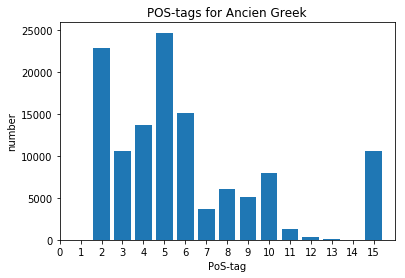

In [31]:
tags_g = [p for sent in Y_train_g for p in sent if p!=0]
print(sorted(tag2index_g.items(), key=operator.itemgetter(1)))
#print(tags_g.count())
num_bins = len(tag2index_g)
#N, bins, patches = plt.hist(tags_g, num_bins, facecolor='blue', alpha=0.5)
labels, counts = np.unique(tags_g, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)

x1,x2,y1,y2 = plt.axis()
plt.axis([0, num_bins,y1,y2])
plt.title("POS-tags for Ancien Greek")
plt.xlabel("PoS-tag")
plt.ylabel("number")
plt.xticks([i for i in range(num_bins)])

plt.show()

В **древнегреческом** преобладают существительные, глаголы, (пунктуация) и прилагательные

[('PAD', 0), ('OOV', 1), ('NOUN', 2), ('CCONJ', 3), ('SCONJ', 4), ('PUNCT', 5), ('VERB', 6), ('ADP', 7), ('DET', 8), ('ADJ', 9), ('PROPN', 10), ('X', 11), ('PRON', 12), ('AUX', 13), ('ADV', 14), ('NUM', 15), ('PART', 16), ('SYM', 17), ('INTJ', 18)]


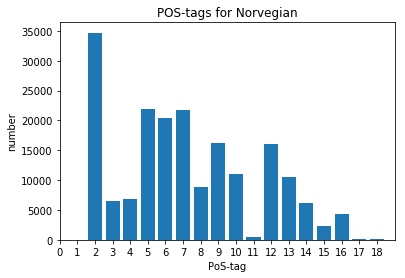

In [32]:
tags_n = [p for sent in Y_train_n for p in sent if p!=0]
print(sorted(tag2index_n.items(), key=operator.itemgetter(1)))

#print(tags_g.count())
num_bins = len(tag2index_n)
#N, bins, patches = plt.hist(tags_g, num_bins, facecolor='blue', alpha=0.5)
labels, counts = np.unique(tags_n, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)

x1,x2,y1,y2 = plt.axis()
plt.axis([0, num_bins,y1,y2])
plt.title("POS-tags for Norvegian")
plt.xlabel("PoS-tag")
plt.ylabel("number")
plt.xticks([i for i in range(num_bins)])

plt.show()

В **норвежском** существительных намного больше, чем других частей речи, затем пунктуация, адпозиции (маркеры синтаксических ролей и связей в препозиции и постпозиции), и только затем глаголы

То, что в норвежском существительных намного больше, чем глаголов, а в древнегреческом они почти на одинаковом уровне, может быть связано с тем, что в древнегреческом глаголы изменяются по лицам => возможен пропуск подлежащего, так как форма глагола на него указывает, тогда как в норвежском глаголы по лицам не изменяются, а значит, наличие подлежащего/субъекта в предложении обязательно  

При этом, хотя это и не отражено на графике, паддингов намного больше, чем существительных в каждом из языков - может доходить ~250 тысяч. Они были искючены из графика, чтобы более наглядно рассмотреть распределение других частей речи

Напишем функции, чтобы быстро строить модель и обрабатывать результаты, не копируя каждый раз:

In [33]:
# построим модель с вариативностью слоя для разных случаев
def make_model(S_MAX_FEATURES, T_MAX_FEATURES, MAX_SEQLEN, LSTM_flag = False, GRU_flag = False, LSTM_Bi = False, Simple = False, EMBEDDING_SIZE = EMB_SIZE):
    global HIDDEN_SIZE
    model = Sequential()
    model.add(Embedding(S_MAX_FEATURES, EMBEDDING_SIZE, input_length=MAX_SEQLEN))
    if LSTM_flag == True:
        model.add(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
        model.add(Dense(T_MAX_FEATURES))
    elif GRU_flag == True:
        model.add(GRU(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
        model.add(Dense(T_MAX_FEATURES))
    elif LSTM_Bi == True:
        model.add(Bidirectional(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
        model.add(TimeDistributed(Dense(T_MAX_FEATURES)))
    elif Simple == True:
        model.add(SimpleRNN(HIDDEN_SIZE, 
                    input_shape=(MAX_SEQLEN, S_MAX_FEATURES),
                    unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
        model.add(Dense(T_MAX_FEATURES))
        
    #model.add(Dense(T_MAX_FEATURES))
    model.add(Activation("softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", 
                  metrics=["acc"])

    print(model.summary())
    return model

In [34]:
# график изменения точности и потери
def plotting(history):
    plt.subplot(211)
    plt.title("Accuracy")
    plt.plot(history.history["acc"], color="r", label="Train")
    plt.plot(history.history["val_acc"], color="b", label="Val")
    plt.legend(loc="best")

    plt.subplot(212)
    plt.title("Loss")
    plt.plot(history.history["loss"], color="r", label="Train")
    plt.plot(history.history["val_loss"], color="b", label="Val")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

In [35]:
# предсказание модели на тестовой выборке

def predict(X_test, Y_test, MAX_SEQLEN, tag2index, model):
    preds = []
    for idx in tqdm(range(len(X_test))):
        #idx = np.random.randint(len(X_test))
        xtest = X_test[idx].reshape(1, MAX_SEQLEN)
        ylabel = Y_test[idx]
        predict = model.predict_classes(xtest)[0] # предскажем теги для одного предложения
        #predict = [np.argmax(k, axis=None, out=None) for k in pred]
        tags_pred = [] # для более наглядного представления переведем числа обратно в теги, исключая паддинги
        tags_ans = [] # и распределим по двум спискам - настоящих ответов и предсказанных моделью
        for p in predict: 
            tags_pred.extend([k for k,v in tag2index.items() if v == p and k!="PAD"]) 
        for t in ylabel:
            tags_ans.extend([k for k,v in tag2index.items() if v == t and k!="PAD"])
        preds.append([pair for pair in zip(tags_ans, tags_pred)]) # спарим правильный ответ с его предсказанием и добавим в общий список предсказаний
    return preds

In [36]:
# так как из-за паддингов результаты точности, подсчитанные керасом, не отражают реальную производительность 
# и точность модели, подсчитаем ее вручную. Ради эксперимента - подсчитаем точность общую и по предложениям (среднюю), 

def acc_manual(pred):
    acc_total = 0
    acc = []
    lens = 0
    for sent in tqdm(pred):
        acc_sent = 0
        for pair in sent:
            if len(set(pair)) == 1:
                acc_sent+=1
                acc_total +=1

        acc_sent = acc_sent/len(sent)
        lens+=len(sent)
        acc.append(acc_sent)

    by_sent = mean(acc)
    print("By sent: ", by_sent*100, "\nTotal: ", acc_total/lens*100)
    return by_sent

In [37]:
scores = {}

In [38]:
X_train_g.shape, Y_train_g.shape

((9180, 26), (9180, 26))

In [39]:
Y_train_g = to_categorical(Y_train_g)
Y_val_g = to_categorical(Y_val_g)

Y_train_n = to_categorical(Y_train_n)
Y_val_n = to_categorical(Y_val_n)

### LSTM

Для древнегреческого:

In [40]:
model_g_lstm = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_flag = True)
checkpoint = ModelCheckpoint('lstm\\lstm_g-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
history_g_lstm = model_g_lstm.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose = 2, callbacks = [checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 150)           4985850   
_________________________________________________________________
lstm_1 (LSTM)                (None, 26, 64)            55040     
_________________________________________________________________
dense_1 (Dense)              (None, 26, 16)            1040      
_________________________________________________________________
activation_1 (Activation)    (None, 26, 16)            0         
Total params: 5,041,930
Trainable params: 5,041,930
Non-trainable params: 0
_________________________________________________________________
None
Train on 9180 samples, validate on 2296 samples
Epoch 1/15
 - 14s - loss: 2.0413 - acc: 0.4715 - val_loss: 1.4721 - val_acc: 0.4906

Epoch 00001: saving model to lstm\lstm_g-1.h5
Epoch 2/15
 - 12s - loss: 1.3961 - acc: 0.5198 - val_loss: 1.3286 - val_acc: 0.5

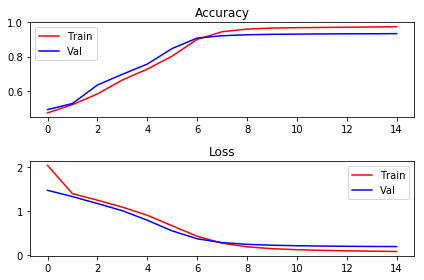

In [41]:
plotting(history_g_lstm)

По графику видно, что переобучение на древнегреческом начинается с 7-й эпохи (6й по графику) (валидационная точнсть перестает увеличиваться  становится меньше тренировочной)

In [42]:
model_g_lstm.load_weights('lstm\\lstm_g-7.h5')

In [43]:
score, acc = model_g_lstm.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=T_MAX_FEATURES_g), verbose = 1)

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 323us/step


In [44]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.521, accuracy: 83.879


In [45]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_g_lstm)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

In [46]:
print("Accuracy without paddings: ")
acc_g = acc_manual(pred_g)

Accuracy without paddings: 


HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  72.02862398418273 
Total:  71.94196657438738


In [47]:
for i, s in enumerate(pred_g[:3]):
    print("Random Sent {}:". format(i+1), *s, sep="\n", end="\n__________\n")

Random Sent 1:
('VERB', 'NOUN')
('ADV', 'PART')
('ADV', 'ADV')
('PRON', 'PRON')
('DET', 'DET')
('PRON', 'ADJ')
('NOUN', 'NOUN')
('DET', 'DET')
('VERB', 'NOUN')
('PUNCT', 'PUNCT')
('NOUN', 'VERB')
('DET', 'DET')
('ADJ', 'ADJ')
('VERB', 'VERB')
('CCONJ', 'CCONJ')
('VERB', 'VERB')
('DET', 'DET')
('NOUN', 'NOUN')
('ADJ', 'ADJ')
('PUNCT', 'PUNCT')
__________
Random Sent 2:
('PRON', 'PRON')
('ADV', 'PART')
('ADJ', 'VERB')
('VERB', 'VERB')
('NOUN', 'VERB')
('ADV', 'ADV')
('ADJ', 'ADJ')
('PRON', 'PRON')
('ADP', 'ADP')
('DET', 'DET')
('ADJ', 'NOUN')
('PRON', 'PRON')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('CCONJ', 'ADV')
('ADV', 'ADV')
('VERB', 'VERB')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
__________
Random Sent 3:
('ADJ', 'NOUN')
('ADV', 'PART')
('ADV', 'ADV')
('PRON', 'PRON')
('ADP', 'ADP')
('PRON', 'PRON')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
__________


Для норвежского:

In [48]:
model_n_lstm = make_model(S_MAX_FEATURES_n, T_MAX_FEATURES_n, MAX_SEQLEN_n, LSTM_flag = True)
checkpoint = ModelCheckpoint('lstm\\lstm_n-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)

history_n = model_n_lstm.fit(X_train_n, Y_train_n, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_n, Y_val_n), verbose = 2, callbacks = [checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 150)           4511100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            55040     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 19)            1235      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 19)            0         
Total params: 4,567,375
Trainable params: 4,567,375
Non-trainable params: 0
_________________________________________________________________
None
Train on 12556 samples, validate on 3140 samples
Epoch 1/15
 - 19s - loss: 1.9924 - acc: 0.4935 - val_loss: 1.4691 - val_acc: 0.5303

Epoch 00001: saving model to lstm\lstm_n-1.h5
Epoch 2/15
 - 16s - loss: 1.4038 - acc: 0.5454 - val_loss: 1.3084 - val_acc: 0.

Построим графики изменения точности и потерь:

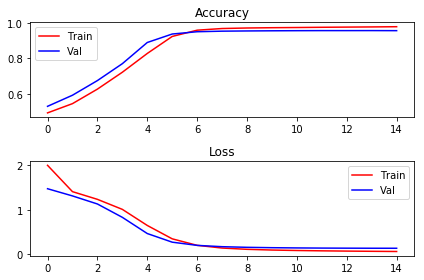

In [49]:
plotting(history_n)

Для норвежского языка, переобучение начинается на 6-й эпохе (5я по графику) (валидационная точность перестает увеличиваться и становится ниже тренировочной)

In [50]:
model_n_lstm.load_weights('lstm\\lstm_n-6.h5')
score, acc = model_n_lstm.evaluate(X_test_n, to_categorical(Y_test_n))

1939/1939 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 386us/step


In [51]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.295, accuracy: 93.139


Из-за большого количества паддингов в данных, модель оценивает результаты предсказаний хорошо, так как паддинги предсказать легко. Попробуем предсказать результаты на тестовой выборке и посчитать точность на получившихся предсказаниях, исключив паддинги

In [52]:
pred_n = predict(X_test_n, Y_test_n, MAX_SEQLEN_n, tag2index_n, model_n_lstm)

HBox(children=(IntProgress(value=0, max=1939), HTML(value='')))

In [53]:
for i, s in enumerate(pred_n[:3]):
    print("Random Sent {}:". format(i+1), *s, sep="\n", end="\n__________\n")

Random Sent 1:
('NOUN', 'NOUN')
('AUX', 'AUX')
('PUNCT', 'PUNCT')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
('NOUN', 'PROPN')
('PUNCT', 'PUNCT')
('CCONJ', 'CCONJ')
('PUNCT', 'PUNCT')
('ADJ', 'NOUN')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
__________
Random Sent 2:
('PRON', 'PRON')
('VERB', 'VERB')
('DET', 'DET')
('NOUN', 'NOUN')
('PRON', 'PRON')
('AUX', 'AUX')
('ADJ', 'VERB')
('CCONJ', 'CCONJ')
('ADP', 'ADP')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
__________
Random Sent 3:
('ADP', 'VERB')
('ADJ', 'ADJ')
('VERB', 'ADJ')
('PRON', 'PRON')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
__________


In [54]:
acc_n = acc_manual(pred_n)

HBox(children=(IntProgress(value=0, max=1939), HTML(value='')))


By sent:  85.54091858210367 
Total:  86.17841219368887


По графикам, модель начинает переобучаться после 6й эпохи => результаты этой эпохи можно считать наиболее оптимальными, поэтому мы загружаем веса данной эпохи в модель и оценивает результаты по ней. Это будем делать для всех моделей

In [55]:
scores["lstm_g"] = acc_g
scores["lstm_n"] = acc_n

In [56]:
scores

{'lstm_g': 0.7202862398418273, 'lstm_n': 0.8554091858210366}

### SimpleRNN

In [57]:
# ancient greek
model_simple_g = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, Simple = True)
checkpoint = ModelCheckpoint('simple\\simple_g-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
history_simple_g = model_simple_g.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose = 2, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 26, 150)           4985850   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 26, 64)            13760     
_________________________________________________________________
dense_3 (Dense)              (None, 26, 16)            1040      
_________________________________________________________________
activation_3 (Activation)    (None, 26, 16)            0         
Total params: 5,000,650
Trainable params: 5,000,650
Non-trainable params: 0
_________________________________________________________________
None
Train on 9180 samples, validate on 2296 samples
Epoch 1/15
 - 11s - loss: 1.9402 - acc: 0.4509 - val_loss: 1.4031 - val_acc: 0.5579

Epoch 00001: saving model to simple\simple_g-1.h5
Epoch 2/15
 - 8s - loss: 1.2555 - acc: 0.6391 - val_loss: 1.0720 - val_acc: 

In [58]:
# norvegian
model_simple_n = make_model(S_MAX_FEATURES_n, T_MAX_FEATURES_n, MAX_SEQLEN_n, Simple = True)
checkpoint = ModelCheckpoint('simple\\simple_n-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
history_simple_n = model_simple_n.fit(X_train_n, Y_train_n, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_n, Y_val_n), verbose = 2, callbacks = [checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 150)           4511100   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 30, 64)            13760     
_________________________________________________________________
dense_4 (Dense)              (None, 30, 19)            1235      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 19)            0         
Total params: 4,526,095
Trainable params: 4,526,095
Non-trainable params: 0
_________________________________________________________________
None
Train on 12556 samples, validate on 3140 samples
Epoch 1/15
 - 14s - loss: 1.8713 - acc: 0.4983 - val_loss: 1.3647 - val_acc: 0.6074

Epoch 00001: saving model to simple\simple_n-1.h5
Epoch 2/15
 - 11s - loss: 1.2611 - acc: 0.6685 - val_loss: 1.0587 - val_acc

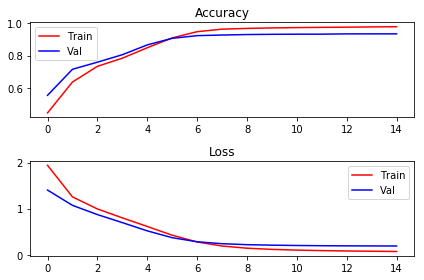

In [59]:
# AG
plotting(history_simple_g)

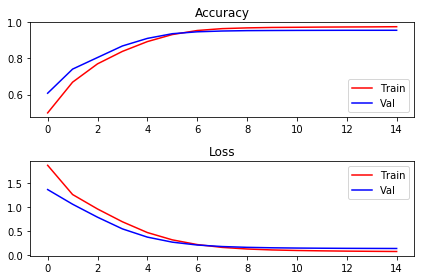

In [60]:
# Norv
plotting(history_simple_n)

По данным графиков: 
* Для древнегреческого, переобучение начинается на 6й (5й по графику) эпохе
* Для норвежского, переобучение начинается на 6й (5й по графику) эпохе

In [61]:
model_simple_g.load_weights('simple\\simple_g-6.h5')
score, acc = model_simple_g.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 203us/step


In [62]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.555, accuracy: 83.004


In [63]:
model_simple_n.load_weights('simple\\simple_n-6.h5')
score, acc = model_simple_n.evaluate(X_test_n, to_categorical(Y_test_n, num_classes=len(tag2index_n)))

1939/1939 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 237us/step


In [64]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.285, accuracy: 92.847


In [65]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_simple_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

In [66]:
for i, s in enumerate(pred_g[:3]):
    print("Random Sent {}:". format(i+1), *s, sep="\n", end="\n__________\n")

Random Sent 1:
('VERB', 'NOUN')
('ADV', 'PART')
('ADV', 'ADV')
('PRON', 'PRON')
('DET', 'PRON')
('PRON', 'ADJ')
('NOUN', 'NOUN')
('DET', 'DET')
('VERB', 'NOUN')
('PUNCT', 'PUNCT')
('NOUN', 'VERB')
('DET', 'DET')
('ADJ', 'ADJ')
('VERB', 'VERB')
('CCONJ', 'CCONJ')
('VERB', 'NOUN')
('DET', 'VERB')
('NOUN', 'NOUN')
('ADJ', 'ADJ')
('PUNCT', 'PUNCT')
__________
Random Sent 2:
('PRON', 'ADJ')
('ADV', 'PART')
('ADJ', 'VERB')
('VERB', 'VERB')
('NOUN', 'ADJ')
('ADV', 'ADV')
('ADJ', 'ADJ')
('PRON', 'VERB')
('ADP', 'ADP')
('DET', 'DET')
('ADJ', 'ADJ')
('PRON', 'PRON')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('CCONJ', 'ADV')
('ADV', 'ADV')
('VERB', 'VERB')
('VERB', 'NOUN')
('PUNCT', 'PUNCT')
__________
Random Sent 3:
('ADJ', 'NOUN')
('ADV', 'PART')
('ADV', 'ADV')
('PRON', 'PRON')
('ADP', 'ADP')
('PRON', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
__________


In [67]:
pred_n = predict(X_test_n, Y_test_n, MAX_SEQLEN_n, tag2index_n, model_simple_n)

HBox(children=(IntProgress(value=0, max=1939), HTML(value='')))

In [68]:
for i, s in enumerate(pred_n[:3]):
    print("Random Sent {}:". format(i+1), *s, sep="\n", end="\n__________\n")

Random Sent 1:
('NOUN', 'ADJ')
('AUX', 'AUX')
('PUNCT', 'PUNCT')
('ADJ', 'NOUN')
('NOUN', 'PROPN')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
('NOUN', 'PROPN')
('PUNCT', 'PUNCT')
('CCONJ', 'CCONJ')
('PUNCT', 'PUNCT')
('ADJ', 'PROPN')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
__________
Random Sent 2:
('PRON', 'PRON')
('VERB', 'VERB')
('DET', 'DET')
('NOUN', 'NOUN')
('PRON', 'PRON')
('AUX', 'AUX')
('ADJ', 'ADJ')
('CCONJ', 'CCONJ')
('ADP', 'ADP')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
__________
Random Sent 3:
('ADP', 'VERB')
('ADJ', 'ADJ')
('VERB', 'NOUN')
('PRON', 'PRON')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
__________


In [69]:
acc_g = acc_manual(pred_g)
acc_n = acc_manual(pred_n)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  70.71963497300916 
Total:  70.41726471191306


HBox(children=(IntProgress(value=0, max=1939), HTML(value='')))


By sent:  84.48598653695497 
Total:  85.37302081172648


In [70]:
scores["simple_g"] = acc_g
scores["simple_n"] = acc_n

In [71]:
scores

{'lstm_g': 0.7202862398418273,
 'lstm_n': 0.8554091858210366,
 'simple_g': 0.7071963497300916,
 'simple_n': 0.8448598653695497}

### Bidirectional

In [72]:
model_bi_g = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_Bi = True)
checkpoint = ModelCheckpoint('bi\\bi_g-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)

history_bi_g = model_bi_g.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2, callbacks = [checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 26, 150)           4985850   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 26, 128)           110080    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 26, 16)            2064      
_________________________________________________________________
activation_5 (Activation)    (None, 26, 16)            0         
Total params: 5,097,994
Trainable params: 5,097,994
Non-trainable params: 0
_________________________________________________________________
None
Train on 9180 samples, validate on 2296 samples
Epoch 1/15
 - 24s - loss: 1.9089 - acc: 0.4913 - val_loss: 1.3291 - val_acc: 0.5874

Epoch 00001: saving model to bi\bi_g-1.h5
Epoch 2/15
 - 21s - loss: 1.2061 - acc: 0.5997 - val_loss: 1.1110 - val_acc: 0.6069


In [73]:
model_bi_n = make_model(S_MAX_FEATURES_n, T_MAX_FEATURES_n, MAX_SEQLEN_n, LSTM_Bi = True)
checkpoint = ModelCheckpoint('bi\\bi_n-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)

history_bi_n = model_bi_n.fit(X_train_n, Y_train_n, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_n, Y_val_n), verbose=2, callbacks = [checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 150)           4511100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 128)           110080    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 19)            2451      
_________________________________________________________________
activation_6 (Activation)    (None, 30, 19)            0         
Total params: 4,623,631
Trainable params: 4,623,631
Non-trainable params: 0
_________________________________________________________________
None
Train on 12556 samples, validate on 3140 samples
Epoch 1/15
 - 45s - loss: 1.8353 - acc: 0.5280 - val_loss: 1.3237 - val_acc: 0.5677

Epoch 00001: saving model to bi\bi_n-1.h5
Epoch 2/15
 - 42s - loss: 1.2345 - acc: 0.5971 - val_loss: 1.1372 - val_acc: 0.6159

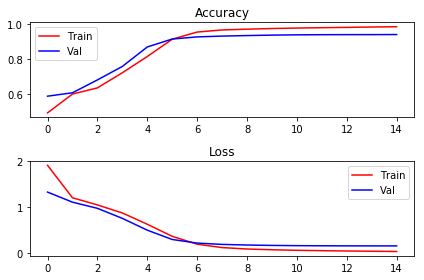

In [74]:
plotting(history_bi_g)

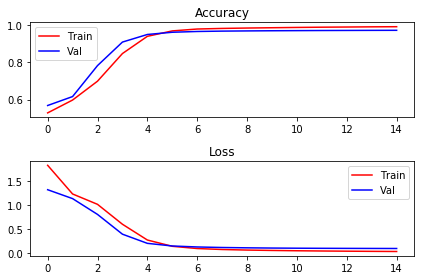

In [75]:
plotting(history_bi_n)

Переобучение начинается:
* Древнегреческий - 6я (5я по графику) эпоха
* Норвежский - 5я (4я по графику) эпоха

In [76]:
model_bi_g.load_weights("bi\\bi_g-6.h5")
score, acc = model_bi_g.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 637us/step


In [77]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.483, accuracy: 82.636


In [78]:
model_bi_n.load_weights("bi\\bi_n-5.h5")
score, acc = model_bi_n.evaluate(X_test_n, to_categorical(Y_test_n, num_classes=len(tag2index_n)))

1939/1939 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 702us/step


In [79]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.225, accuracy: 94.045


In [80]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_bi_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

In [81]:
for i, s in enumerate(pred_g[:3]):
    print("Random Sent {}:". format(i+1), *s, sep="\n", end="\n__________\n")

Random Sent 1:
('VERB', 'VERB')
('ADV', 'PART')
('ADV', 'ADV')
('PRON', 'PRON')
('DET', 'DET')
('PRON', 'ADJ')
('NOUN', 'NOUN')
('DET', 'DET')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('NOUN', 'VERB')
('DET', 'DET')
('ADJ', 'ADJ')
('VERB', 'VERB')
('CCONJ', 'CCONJ')
('VERB', 'VERB')
('DET', 'DET')
('NOUN', 'NOUN')
('ADJ', 'VERB')
('PUNCT', 'PUNCT')
__________
Random Sent 2:
('PRON', 'PRON')
('ADV', 'PART')
('ADJ', 'VERB')
('VERB', 'VERB')
('NOUN', 'VERB')
('ADV', 'ADV')
('ADJ', 'ADJ')
('PRON', 'ADJ')
('ADP', 'ADP')
('DET', 'DET')
('ADJ', 'ADJ')
('PRON', 'PRON')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('CCONJ', 'ADV')
('ADV', 'ADV')
('VERB', 'VERB')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
__________
Random Sent 3:
('ADJ', 'VERB')
('ADV', 'PART')
('ADV', 'ADV')
('PRON', 'PRON')
('ADP', 'ADP')
('PRON', 'PRON')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
__________


In [82]:
pred_n = predict(X_test_n, Y_test_n, MAX_SEQLEN_n, tag2index_n, model_bi_n)

HBox(children=(IntProgress(value=0, max=1939), HTML(value='')))

In [83]:
for i, s in enumerate(pred_n[:3]):
    print("Random Sent {}:". format(i+1), *s, sep="\n", end="\n__________\n")

Random Sent 1:
('NOUN', 'NOUN')
('AUX', 'AUX')
('PUNCT', 'PUNCT')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
('NOUN', 'PROPN')
('PUNCT', 'PUNCT')
('CCONJ', 'CCONJ')
('PUNCT', 'PUNCT')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
__________
Random Sent 2:
('PRON', 'PRON')
('VERB', 'VERB')
('DET', 'DET')
('NOUN', 'NOUN')
('PRON', 'PRON')
('AUX', 'AUX')
('ADJ', 'ADJ')
('CCONJ', 'CCONJ')
('ADP', 'ADP')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
__________
Random Sent 3:
('ADP', 'NOUN')
('ADJ', 'ADJ')
('VERB', 'VERB')
('PRON', 'PRON')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
__________


In [84]:
acc_g = acc_manual(pred_g)
acc_n = acc_manual(pred_n)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  69.91575530395838 
Total:  69.78317699523296


HBox(children=(IntProgress(value=0, max=1939), HTML(value='')))


By sent:  87.43860769196615 
Total:  88.04103768696675


In [85]:
scores["bi_g"] = acc_g
scores["bi_n"] = acc_n

In [86]:
scores

{'bi_g': 0.6991575530395837,
 'bi_n': 0.8743860769196615,
 'lstm_g': 0.7202862398418273,
 'lstm_n': 0.8554091858210366,
 'simple_g': 0.7071963497300916,
 'simple_n': 0.8448598653695497}

### GRU

In [87]:
model_gru_g = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, GRU_flag = True)
checkpoint = ModelCheckpoint('gru\\gru_g-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
history_gru_g = model_gru_g.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 26, 150)           4985850   
_________________________________________________________________
gru_1 (GRU)                  (None, 26, 64)            41280     
_________________________________________________________________
dense_7 (Dense)              (None, 26, 16)            1040      
_________________________________________________________________
activation_7 (Activation)    (None, 26, 16)            0         
Total params: 5,028,170
Trainable params: 5,028,170
Non-trainable params: 0
_________________________________________________________________
None
Train on 9180 samples, validate on 2296 samples
Epoch 1/15
 - 18s - loss: 2.0489 - acc: 0.4854 - val_loss: 1.3880 - val_acc: 0.5989

Epoch 00001: saving model to gru\gru_g-1.h5
Epoch 2/15
 - 16s - loss: 1.2900 - acc: 0.6851 - val_loss: 1.1697 - val_acc: 0.716

In [88]:
model_gru_n = make_model(S_MAX_FEATURES_n, T_MAX_FEATURES_n, MAX_SEQLEN_n, GRU_flag = True)
checkpoint = ModelCheckpoint('gru\\gru_n-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)

history_gru_n = model_gru_n.fit(X_train_n, Y_train_n, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_n, Y_val_n), verbose=2, callbacks = [checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 150)           4511100   
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            41280     
_________________________________________________________________
dense_8 (Dense)              (None, 30, 19)            1235      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 19)            0         
Total params: 4,553,615
Trainable params: 4,553,615
Non-trainable params: 0
_________________________________________________________________
None
Train on 12556 samples, validate on 3140 samples
Epoch 1/15
 - 25s - loss: 1.9588 - acc: 0.5784 - val_loss: 1.3563 - val_acc: 0.7295

Epoch 00001: saving model to gru\gru_n-1.h5
Epoch 2/15
 - 22s - loss: 1.1825 - acc: 0.7345 - val_loss: 0.9216 - val_acc: 0.76

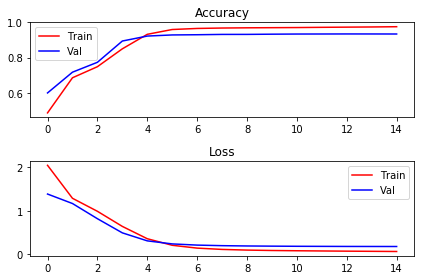

In [89]:
plotting(history_gru_g)

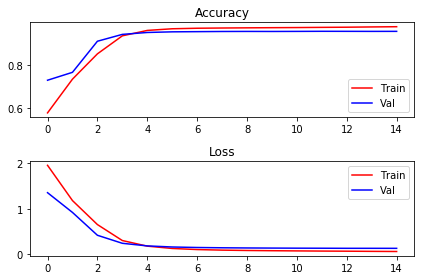

In [90]:
plotting(history_gru_n)

Переобучение:
* Древнегреческий - 4я (3я по графику) эпоха
* Норвежский - 3я (2я по графику) эпоха

In [91]:
model_gru_g.load_weights("gru\\gru_g-4.h5")
score, acc = model_gru_g.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 370us/step


In [92]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.697, accuracy: 82.012


In [93]:
model_gru_n.load_weights("gru\\gru_n-3.h5")
score, acc = model_gru_n.evaluate(X_test_n, to_categorical(Y_test_n))

1939/1939 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 439us/step


In [94]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.433, accuracy: 90.395


In [95]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_gru_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

In [96]:
for i, s in enumerate(pred_g[:3]):
    print("Random Sent {}:". format(i+1), *s, sep="\n", end="\n__________\n")

Random Sent 1:
('VERB', 'VERB')
('ADV', 'PART')
('ADV', 'ADV')
('PRON', 'PRON')
('DET', 'DET')
('PRON', 'ADJ')
('NOUN', 'NOUN')
('DET', 'DET')
('VERB', 'NOUN')
('PUNCT', 'PUNCT')
('NOUN', 'VERB')
('DET', 'DET')
('ADJ', 'ADJ')
('VERB', 'VERB')
('CCONJ', 'CCONJ')
('VERB', 'NOUN')
('DET', 'DET')
('NOUN', 'NOUN')
('ADJ', 'VERB')
('PUNCT', 'PUNCT')
__________
Random Sent 2:
('PRON', 'ADJ')
('ADV', 'PART')
('ADJ', 'VERB')
('VERB', 'VERB')
('NOUN', 'VERB')
('ADV', 'ADV')
('ADJ', 'ADJ')
('PRON', 'ADJ')
('ADP', 'ADP')
('DET', 'PRON')
('ADJ', 'NOUN')
('PRON', 'PRON')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('CCONJ', 'ADV')
('ADV', 'NOUN')
('VERB', 'VERB')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
__________
Random Sent 3:
('ADJ', 'VERB')
('ADV', 'PART')
('ADV', 'ADV')
('PRON', 'ADJ')
('ADP', 'ADP')
('PRON', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
__________


In [97]:
pred_n = predict(X_test_n, Y_test_n, MAX_SEQLEN_n, tag2index_n, model_gru_n)

HBox(children=(IntProgress(value=0, max=1939), HTML(value='')))

In [98]:
for i, s in enumerate(pred_n[:3]):
    print("Random Sent {}:". format(i+1), *s, sep="\n", end="\n__________\n")

Random Sent 1:
('NOUN', 'ADJ')
('AUX', 'AUX')
('PUNCT', 'PUNCT')
('ADJ', 'NOUN')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('CCONJ', 'CCONJ')
('PUNCT', 'PUNCT')
('ADJ', 'NOUN')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('PUNCT', 'PUNCT')
__________
Random Sent 2:
('PRON', 'PRON')
('VERB', 'VERB')
('DET', 'DET')
('NOUN', 'NOUN')
('PRON', 'PRON')
('AUX', 'AUX')
('ADJ', 'VERB')
('CCONJ', 'CCONJ')
('ADP', 'ADP')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
__________
Random Sent 3:
('ADP', 'NOUN')
('ADJ', 'ADJ')
('VERB', 'ADJ')
('PRON', 'PRON')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
__________


In [99]:
acc_g = acc_manual(pred_g)
acc_n = acc_manual(pred_n)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  68.89414970120427 
Total:  68.70706449297653


HBox(children=(IntProgress(value=0, max=1939), HTML(value='')))


By sent:  78.5635765802608 
Total:  79.58596296553159


In [100]:
scores["gru_g"] = acc_g
scores["gru_n"] = acc_n

In [101]:
scores

{'bi_g': 0.6991575530395837,
 'bi_n': 0.8743860769196615,
 'gru_g': 0.6889414970120427,
 'gru_n': 0.785635765802608,
 'lstm_g': 0.7202862398418273,
 'lstm_n': 0.8554091858210366,
 'simple_g': 0.7071963497300916,
 'simple_n': 0.8448598653695497}

### Выводы и анализ

In [102]:
scores_g = {k : round(v*100,3) for k,v in scores.items() if "_g" in k}

In [103]:
scores_n = {k : round(v*100,3) for k,v in scores.items() if "_n" in k}

In [104]:
scores_g, scores_n

({'bi_g': 69.916, 'gru_g': 68.894, 'lstm_g': 72.029, 'simple_g': 70.72},
 {'bi_n': 87.439, 'gru_n': 78.564, 'lstm_n': 85.541, 'simple_n': 84.486})

In [105]:
print("Точности для древнегреческого языка:")
for k, v in sorted(scores_g.items(), key=operator.itemgetter(1)):
    print("\t",k, ":",v)

Точности для древнегреческого языка:
	 gru_g : 68.894
	 bi_g : 69.916
	 simple_g : 70.72
	 lstm_g : 72.029


**Выводы по разметке древнегреческого языка:**

* Все модели показали примерно одинаковую точность - от 68 до 72%. Древнегреческия достаточно сложный для разметки - у каждой части речи большое количество различных возможных форм; формы выражаются флексиями, интерфиксами, etc., то есть внутри слова, сложная словоизменительная система - большое количество разных вариаций слов относится к одной части речи, но при помоци флексий образовываются и другие части речи; свободный порядок слов (хотя есть и определенные првила, напр. сказуемое чаще всего в конце, но они свободно нарушаются, и по большей частии сложные (зависят от формы) и вариативные). 
* Лучше всего (очень близкие результаты с разницей в сотые доли) с разметкой справилась простая lstm - как уже было сказано, порядок слов хоть и свободный, но есть небольшое количество правил + стандартно, есть определенные типичные сочетания частей речи (напр., существительное + прилагательное, которое к нему относится, существительное + артиклиь и тд), и зависимость есть, судя по всему, именно от предыдущего контекста. И судя по результату двунаправленной, "будущее состояние" контекста, которое учитывается в двунаправленной lstm, только ухудшает результат.
* Самые низкие результаты - у gru. Согласно теории, в отличие от lstm, есть только фильтр обновления и фильтр забывания. Возможно, отсутствие "постоянного состояния ячейки" приводит к тому, что слишком много информации модель выбрасывает. Поэтому даже простая рекуррентная сеть, хотя и не способна моделировать дальний контекст, показывает лучшие результаты - видимо, определяя правила сочетаемости

In [106]:
print("Точности для норвежского языка:")
for k, v in sorted(scores_n.items(), key=operator.itemgetter(1)):
    print("\t",k, ":",v)

Точности для норвежского языка:
	 gru_n : 78.564
	 simple_n : 84.486
	 lstm_n : 85.541
	 bi_n : 87.439


**Выводы по разметке древнегреческого языка:**
* Показател различаются сильнее, чем для греческого, что связано с тем, что норвежский более аналитичный и более определенный по морфологии.
* Лучше всего справилась двунаправленная lstm, учитывающая контекст в обе стороны. Норвежский язык более аналитичен, у частей речи меньше форм, они яснее определены, порядок слов фиксированный за редким исключением, когда его изменение продиктовано стилистическими требованиями, у членов предложения есть определенное место. Поэтому учитывая и предыдущий, и будущий широкий контекст предложения модель может более менее точно построить его структуру, так как она фиксирована.
* При этом результаты простой ЛСТМ и простой рекуррентной сети оказались примерно одинаковыми и не намного ниже результатов двунаправленной. Опять же, аналитичность языка и фиксированный порядок слов в предложениях намного упрощают разметку текста (в отличие от древнегреческого)
* Хуже всего результаты у GRU. Возможно, по той же причине, что и у древнегреческого - слишком много информации выбрасывается, и учитывая достаточно большую разницу, возможно, меньше внимания уделяется ближайшему контексту.

**Общие выводы**:
* Для частеречной разметки древнегреческого языка важен предыдущий дальний контекст, который моделируется слоем lstm. Для норвежского контекст так же важен, так как он позволяет выявить структуру типичного предложения, но при этом вполне может игнорироваться с небольшой потерей точности.
* Норвежский язык проще размечать автоматически, чем древнегреческий по причине его аналитичности и фиксированного порядка слов, поэтому точность у него в целом выше
* По большей части, норвежский переобучается быстрее, чем древнегреческий, по причине, указанной в предыдущем пункте

### Embedding Size

Сравним, как повлияет изменение размера эмбеддинга для разных моделей на примере древнегреческого языка как более сложного для разметки

#### LSTM

In [397]:
model_lstm = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_flag = True, EMBEDDING_SIZE = 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 26, 100)           3323900   
_________________________________________________________________
lstm_18 (LSTM)               (None, 26, 64)            42240     
_________________________________________________________________
dense_34 (Dense)             (None, 26, 16)            1040      
_________________________________________________________________
activation_34 (Activation)   (None, 26, 16)            0         
Total params: 3,367,180
Trainable params: 3,367,180
Non-trainable params: 0
_________________________________________________________________
None


In [398]:
model_lstm.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose = 2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 41s - loss: 2.1145 - acc: 0.4684 - val_loss: 1.5371 - val_acc: 0.4889
Epoch 2/10
 - 34s - loss: 1.4384 - acc: 0.5111 - val_loss: 1.3616 - val_acc: 0.5265
Epoch 3/10
 - 36s - loss: 1.2834 - acc: 0.5706 - val_loss: 1.2138 - val_acc: 0.6131
Epoch 4/10
 - 34s - loss: 1.1508 - acc: 0.6276 - val_loss: 1.0945 - val_acc: 0.6498
Epoch 5/10
 - 32s - loss: 1.0392 - acc: 0.6618 - val_loss: 0.9831 - val_acc: 0.6933
Epoch 6/10
 - 32s - loss: 0.9049 - acc: 0.7224 - val_loss: 0.8199 - val_acc: 0.7441
Epoch 7/10
 - 33s - loss: 0.7275 - acc: 0.7736 - val_loss: 0.6436 - val_acc: 0.7961
Epoch 8/10
 - 33s - loss: 0.5428 - acc: 0.8524 - val_loss: 0.4785 - val_acc: 0.8794
Epoch 9/10
 - 34s - loss: 0.3750 - acc: 0.9230 - val_loss: 0.3583 - val_acc: 0.9108
Epoch 10/10
 - 33s - loss: 0.2575 - acc: 0.9521 - val_loss: 0.2914 - val_acc: 0.9178


In [399]:
score, acc = model_lstm.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 473us/step


In [400]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.517, accuracy: 82.551


In [401]:
acc_lstm = {}

In [402]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_lstm)
acc_lstm[100] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  69.45967818588312 
Total:  69.5904034449172


In [404]:
model_lstm = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_flag = True, EMBEDDING_SIZE = 200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 26, 200)           6647800   
_________________________________________________________________
lstm_19 (LSTM)               (None, 26, 64)            67840     
_________________________________________________________________
dense_35 (Dense)             (None, 26, 16)            1040      
_________________________________________________________________
activation_35 (Activation)   (None, 26, 16)            0         
Total params: 6,716,680
Trainable params: 6,716,680
Non-trainable params: 0
_________________________________________________________________
None


In [405]:
model_lstm.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 46s - loss: 1.9374 - acc: 0.4811 - val_loss: 1.4606 - val_acc: 0.5123
Epoch 2/10
 - 39s - loss: 1.3873 - acc: 0.5274 - val_loss: 1.3215 - val_acc: 0.5223
Epoch 3/10
 - 37s - loss: 1.2273 - acc: 0.5790 - val_loss: 1.1345 - val_acc: 0.6318
Epoch 4/10
 - 39s - loss: 1.0413 - acc: 0.6680 - val_loss: 0.9447 - val_acc: 0.7108
Epoch 5/10
 - 38s - loss: 0.8227 - acc: 0.7523 - val_loss: 0.7033 - val_acc: 0.7972
Epoch 6/10
 - 40s - loss: 0.5667 - acc: 0.8576 - val_loss: 0.4680 - val_acc: 0.8870
Epoch 7/10
 - 38s - loss: 0.3442 - acc: 0.9334 - val_loss: 0.3245 - val_acc: 0.9183
Epoch 8/10
 - 38s - loss: 0.2157 - acc: 0.9593 - val_loss: 0.2614 - val_acc: 0.9255
Epoch 9/10
 - 38s - loss: 0.1548 - acc: 0.9660 - val_loss: 0.2316 - val_acc: 0.9286
Epoch 10/10
 - 37s - loss: 0.1239 - acc: 0.9685 - val_loss: 0.2157 - val_acc: 0.9295


In [406]:
score, acc = model_lstm.evaluate(X_test_g, to_categorical(Y_test_g, num_classes = len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1000us/step


In [407]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.402, accuracy: 85.210


In [408]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_lstm)
acc_lstm[200] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  74.22765934338975 
Total:  74.21570637687103


In [409]:
model_lstm = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_flag = True, EMBEDDING_SIZE = 300)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 26, 300)           9971700   
_________________________________________________________________
lstm_20 (LSTM)               (None, 26, 64)            93440     
_________________________________________________________________
dense_36 (Dense)             (None, 26, 16)            1040      
_________________________________________________________________
activation_36 (Activation)   (None, 26, 16)            0         
Total params: 10,066,180
Trainable params: 10,066,180
Non-trainable params: 0
_________________________________________________________________
None


In [411]:
model_lstm.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 46s - loss: 1.4984 - acc: 0.5202 - val_loss: 1.3553 - val_acc: 0.5331
Epoch 2/10
 - 45s - loss: 1.2586 - acc: 0.5758 - val_loss: 1.1606 - val_acc: 0.6393
Epoch 3/10
 - 45s - loss: 1.0580 - acc: 0.6747 - val_loss: 0.9477 - val_acc: 0.7161
Epoch 4/10
 - 45s - loss: 0.8116 - acc: 0.7522 - val_loss: 0.6768 - val_acc: 0.8043
Epoch 5/10
 - 45s - loss: 0.5264 - acc: 0.8778 - val_loss: 0.4214 - val_acc: 0.9023
Epoch 6/10
 - 45s - loss: 0.2963 - acc: 0.9436 - val_loss: 0.2858 - val_acc: 0.9231
Epoch 7/10
 - 45s - loss: 0.1795 - acc: 0.9628 - val_loss: 0.2356 - val_acc: 0.9273
Epoch 8/10
 - 45s - loss: 0.1300 - acc: 0.9674 - val_loss: 0.2145 - val_acc: 0.9291
Epoch 9/10
 - 45s - loss: 0.1067 - acc: 0.9699 - val_loss: 0.2031 - val_acc: 0.9314
Epoch 10/10
 - 45s - loss: 0.0923 - acc: 0.9715 - val_loss: 0.1962 - val_acc: 0.9325


In [413]:
score, acc = model_lstm.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 3ms/step


In [414]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.386, accuracy: 86.017


In [415]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_lstm)
acc_lstm[300] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  75.48620169260356 
Total:  75.67276641550053


#### SimpleRNN

In [419]:
acc_simp = {}

In [420]:
model_simple = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, Simple = True, EMBEDDING_SIZE = 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 26, 100)           3323900   
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 26, 64)            10560     
_________________________________________________________________
dense_37 (Dense)             (None, 26, 16)            1040      
_________________________________________________________________
activation_37 (Activation)   (None, 26, 16)            0         
Total params: 3,335,500
Trainable params: 3,335,500
Non-trainable params: 0
_________________________________________________________________
None


In [422]:
model_simple.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 12s - loss: 1.6397 - acc: 0.5188 - val_loss: 1.3437 - val_acc: 0.5311
Epoch 2/10
 - 11s - loss: 1.2604 - acc: 0.6058 - val_loss: 1.0976 - val_acc: 0.6878
Epoch 3/10
 - 11s - loss: 1.0320 - acc: 0.7057 - val_loss: 0.9142 - val_acc: 0.7432
Epoch 4/10
 - 10s - loss: 0.8391 - acc: 0.7660 - val_loss: 0.7303 - val_acc: 0.7924
Epoch 5/10
 - 11s - loss: 0.6523 - acc: 0.8268 - val_loss: 0.5575 - val_acc: 0.8452
Epoch 6/10
 - 10s - loss: 0.4787 - acc: 0.8843 - val_loss: 0.4147 - val_acc: 0.8882
Epoch 7/10
 - 10s - loss: 0.3374 - acc: 0.9271 - val_loss: 0.3173 - val_acc: 0.9141
Epoch 8/10
 - 10s - loss: 0.2358 - acc: 0.9520 - val_loss: 0.2596 - val_acc: 0.9234
Epoch 9/10
 - 10s - loss: 0.1734 - acc: 0.9619 - val_loss: 0.2281 - val_acc: 0.9272
Epoch 10/10
 - 10s - loss: 0.1361 - acc: 0.9661 - val_loss: 0.2117 - val_acc: 0.9297


In [424]:
score, acc = model_simple.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 331us/step


In [425]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.418, accuracy: 84.880


In [429]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_simple)
acc_simp[100] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  72.97772838262233 
Total:  73.57435897435897


In [434]:
model_simple = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, Simple = True, EMBEDDING_SIZE = 200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 26, 200)           6647800   
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 26, 64)            16960     
_________________________________________________________________
dense_39 (Dense)             (None, 26, 16)            1040      
_________________________________________________________________
activation_39 (Activation)   (None, 26, 16)            0         
Total params: 6,665,800
Trainable params: 6,665,800
Non-trainable params: 0
_________________________________________________________________
None


In [435]:
model_simple.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 23s - loss: 1.8687 - acc: 0.4697 - val_loss: 1.3813 - val_acc: 0.5616
Epoch 2/10
 - 15s - loss: 1.2596 - acc: 0.6400 - val_loss: 1.0671 - val_acc: 0.7118
Epoch 3/10
 - 16s - loss: 0.9778 - acc: 0.7340 - val_loss: 0.8548 - val_acc: 0.7558
Epoch 4/10
 - 15s - loss: 0.7854 - acc: 0.7837 - val_loss: 0.6876 - val_acc: 0.8059
Epoch 5/10
 - 15s - loss: 0.6021 - acc: 0.8491 - val_loss: 0.5126 - val_acc: 0.8689
Epoch 6/10
 - 15s - loss: 0.4160 - acc: 0.9094 - val_loss: 0.3649 - val_acc: 0.9087
Epoch 7/10
 - 15s - loss: 0.2721 - acc: 0.9465 - val_loss: 0.2769 - val_acc: 0.9235
Epoch 8/10
 - 15s - loss: 0.1842 - acc: 0.9614 - val_loss: 0.2340 - val_acc: 0.9274
Epoch 9/10
 - 15s - loss: 0.1378 - acc: 0.9666 - val_loss: 0.2136 - val_acc: 0.9301
Epoch 10/10
 - 15s - loss: 0.1134 - acc: 0.9687 - val_loss: 0.2033 - val_acc: 0.9307


In [437]:
score, acc = model_simple.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 580us/step


In [438]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.381, accuracy: 85.319


In [439]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_simple)
acc_simp[200] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  73.89856415463399 
Total:  74.3100441161383


In [440]:
model_simple = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, Simple = True, EMBEDDING_SIZE = 300)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 26, 300)           9971700   
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 26, 64)            23360     
_________________________________________________________________
dense_40 (Dense)             (None, 26, 16)            1040      
_________________________________________________________________
activation_40 (Activation)   (None, 26, 16)            0         
Total params: 9,996,100
Trainable params: 9,996,100
Non-trainable params: 0
_________________________________________________________________
None


In [442]:
model_simple.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 21s - loss: 1.4889 - acc: 0.5782 - val_loss: 1.1566 - val_acc: 0.7075
Epoch 2/10
 - 20s - loss: 1.0504 - acc: 0.7140 - val_loss: 0.8957 - val_acc: 0.7506
Epoch 3/10
 - 19s - loss: 0.7987 - acc: 0.7903 - val_loss: 0.6766 - val_acc: 0.8195
Epoch 4/10
 - 20s - loss: 0.5633 - acc: 0.8760 - val_loss: 0.4565 - val_acc: 0.8928
Epoch 5/10
 - 21s - loss: 0.3433 - acc: 0.9365 - val_loss: 0.3091 - val_acc: 0.9204
Epoch 6/10
 - 21s - loss: 0.2079 - acc: 0.9592 - val_loss: 0.2455 - val_acc: 0.9269
Epoch 7/10
 - 20s - loss: 0.1438 - acc: 0.9661 - val_loss: 0.2189 - val_acc: 0.9297
Epoch 8/10
 - 20s - loss: 0.1134 - acc: 0.9691 - val_loss: 0.2069 - val_acc: 0.9321
Epoch 9/10
 - 20s - loss: 0.0971 - acc: 0.9709 - val_loss: 0.1996 - val_acc: 0.9326
Epoch 10/10
 - 21s - loss: 0.0865 - acc: 0.9724 - val_loss: 0.1959 - val_acc: 0.9332


In [443]:
score, acc = model_simple.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 1ms/step


In [444]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.391, accuracy: 85.770


In [445]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_simple)
acc_simp[300] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  74.56628610989655 
Total:  74.8729792147806


#### Bidirectional

In [57]:
acc_bi = {}

In [58]:
model_bi = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_Bi = True, EMBEDDING_SIZE = 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 26, 100)           3323900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 26, 128)           84480     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 26, 16)            2064      
_________________________________________________________________
activation_4 (Activation)    (None, 26, 16)            0         
Total params: 3,410,444
Trainable params: 3,410,444
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
model_bi.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 18s - loss: 2.0259 - acc: 0.4687 - val_loss: 1.3997 - val_acc: 0.5517
Epoch 2/10
 - 14s - loss: 1.2678 - acc: 0.5811 - val_loss: 1.1644 - val_acc: 0.6081
Epoch 3/10
 - 15s - loss: 1.1136 - acc: 0.6111 - val_loss: 1.0673 - val_acc: 0.6251
Epoch 4/10
 - 14s - loss: 1.0159 - acc: 0.6470 - val_loss: 0.9467 - val_acc: 0.6991
Epoch 5/10
 - 15s - loss: 0.8538 - acc: 0.7304 - val_loss: 0.7497 - val_acc: 0.7687
Epoch 6/10
 - 17s - loss: 0.6416 - acc: 0.8168 - val_loss: 0.5372 - val_acc: 0.8571
Epoch 7/10
 - 18s - loss: 0.4279 - acc: 0.8992 - val_loss: 0.3616 - val_acc: 0.9048
Epoch 8/10
 - 16s - loss: 0.2603 - acc: 0.9482 - val_loss: 0.2581 - val_acc: 0.9217
Epoch 9/10
 - 16s - loss: 0.1624 - acc: 0.9656 - val_loss: 0.2140 - val_acc: 0.9282
Epoch 10/10
 - 16s - loss: 0.1176 - acc: 0.9714 - val_loss: 0.1947 - val_acc: 0.9301


In [60]:
score, acc = model_bi.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 584us/step


In [61]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.390, accuracy: 83.844


In [62]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_bi)
acc_bi[100] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  71.52516861219344 
Total:  71.91040032805371


In [63]:
model_bi = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_Bi = True, EMBEDDING_SIZE = 200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 26, 200)           6647800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 26, 128)           135680    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 26, 16)            2064      
_________________________________________________________________
activation_5 (Activation)    (None, 26, 16)            0         
Total params: 6,785,544
Trainable params: 6,785,544
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
model_bi.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 29s - loss: 1.8590 - acc: 0.5000 - val_loss: 1.2954 - val_acc: 0.5972
Epoch 2/10
 - 24s - loss: 1.1719 - acc: 0.6121 - val_loss: 1.0727 - val_acc: 0.6416
Epoch 3/10
 - 24s - loss: 0.9895 - acc: 0.6776 - val_loss: 0.8775 - val_acc: 0.7408
Epoch 4/10
 - 25s - loss: 0.7478 - acc: 0.7848 - val_loss: 0.6028 - val_acc: 0.8384
Epoch 5/10
 - 26s - loss: 0.4483 - acc: 0.8963 - val_loss: 0.3500 - val_acc: 0.9059
Epoch 6/10
 - 26s - loss: 0.2338 - acc: 0.9510 - val_loss: 0.2388 - val_acc: 0.9254
Epoch 7/10
 - 26s - loss: 0.1352 - acc: 0.9700 - val_loss: 0.1994 - val_acc: 0.9298
Epoch 8/10
 - 26s - loss: 0.0956 - acc: 0.9748 - val_loss: 0.1828 - val_acc: 0.9330
Epoch 9/10
 - 27s - loss: 0.0768 - acc: 0.9780 - val_loss: 0.1744 - val_acc: 0.9349
Epoch 10/10
 - 27s - loss: 0.0656 - acc: 0.9805 - val_loss: 0.1691 - val_acc: 0.9369


In [65]:
score, acc = model_bi.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 795us/step


In [66]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.354, accuracy: 85.687


In [67]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_bi)
acc_bi[200] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  74.4698081895281 
Total:  75.1345808766983


In [68]:
model_bi = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_Bi = True, EMBEDDING_SIZE = 300)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 26, 300)           9971700   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 26, 128)           186880    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 26, 16)            2064      
_________________________________________________________________
activation_6 (Activation)    (None, 26, 16)            0         
Total params: 10,160,644
Trainable params: 10,160,644
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
model_bi.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 40s - loss: 1.8147 - acc: 0.4977 - val_loss: 1.2643 - val_acc: 0.6203
Epoch 2/10
 - 36s - loss: 1.1223 - acc: 0.6365 - val_loss: 0.9955 - val_acc: 0.6776
Epoch 3/10
 - 36s - loss: 0.8628 - acc: 0.7347 - val_loss: 0.7030 - val_acc: 0.7968
Epoch 4/10
 - 36s - loss: 0.5192 - acc: 0.8666 - val_loss: 0.3674 - val_acc: 0.9026
Epoch 5/10
 - 36s - loss: 0.2345 - acc: 0.9492 - val_loss: 0.2269 - val_acc: 0.9281
Epoch 6/10
 - 37s - loss: 0.1261 - acc: 0.9690 - val_loss: 0.1896 - val_acc: 0.9336
Epoch 7/10
 - 36s - loss: 0.0904 - acc: 0.9743 - val_loss: 0.1757 - val_acc: 0.9368
Epoch 8/10
 - 37s - loss: 0.0738 - acc: 0.9774 - val_loss: 0.1690 - val_acc: 0.9383
Epoch 9/10
 - 38s - loss: 0.0628 - acc: 0.9806 - val_loss: 0.1647 - val_acc: 0.9398
Epoch 10/10
 - 37s - loss: 0.0547 - acc: 0.9826 - val_loss: 0.1618 - val_acc: 0.9406


In [70]:
score, acc = model_bi.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 2ms/step


In [71]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.336, accuracy: 87.737


In [73]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_bi)
acc_bi[300] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  78.1361812268994 
Total:  78.65709892362891


#### GRU

In [37]:
acc_gru = {}

In [39]:
model_gru = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, GRU_flag = True, EMBEDDING_SIZE = 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 100)           3323900   
_________________________________________________________________
gru_1 (GRU)                  (None, 26, 64)            31680     
_________________________________________________________________
dense_1 (Dense)              (None, 26, 16)            1040      
_________________________________________________________________
activation_1 (Activation)    (None, 26, 16)            0         
Total params: 3,356,620
Trainable params: 3,356,620
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
model_gru.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 9s - loss: 2.0659 - acc: 0.4821 - val_loss: 1.4210 - val_acc: 0.5118
Epoch 2/10
 - 7s - loss: 1.3483 - acc: 0.6257 - val_loss: 1.2846 - val_acc: 0.6156
Epoch 3/10
 - 7s - loss: 1.1606 - acc: 0.6615 - val_loss: 1.0022 - val_acc: 0.6951
Epoch 4/10
 - 7s - loss: 0.8362 - acc: 0.7611 - val_loss: 0.6769 - val_acc: 0.8156
Epoch 5/10
 - 7s - loss: 0.5389 - acc: 0.8825 - val_loss: 0.4375 - val_acc: 0.9034
Epoch 6/10
 - 7s - loss: 0.3283 - acc: 0.9371 - val_loss: 0.3069 - val_acc: 0.9215
Epoch 7/10
 - 7s - loss: 0.2117 - acc: 0.9579 - val_loss: 0.2481 - val_acc: 0.9285
Epoch 8/10
 - 7s - loss: 0.1519 - acc: 0.9648 - val_loss: 0.2207 - val_acc: 0.9299
Epoch 9/10
 - 7s - loss: 0.1208 - acc: 0.9674 - val_loss: 0.2070 - val_acc: 0.9307
Epoch 10/10
 - 7s - loss: 0.1042 - acc: 0.9684 - val_loss: 0.1993 - val_acc: 0.9314


In [43]:
score, acc = model_gru.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 253us/step


In [44]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.397, accuracy: 84.957


In [45]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_gru)
acc_gru[100] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  73.1416779686592 
Total:  73.6974358974359


In [46]:
model_gru = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, GRU_flag = True, EMBEDDING_SIZE = 200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 26, 200)           6647800   
_________________________________________________________________
gru_2 (GRU)                  (None, 26, 64)            50880     
_________________________________________________________________
dense_2 (Dense)              (None, 26, 16)            1040      
_________________________________________________________________
activation_2 (Activation)    (None, 26, 16)            0         
Total params: 6,699,720
Trainable params: 6,699,720
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
model_gru.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 14s - loss: 1.9474 - acc: 0.5207 - val_loss: 1.3594 - val_acc: 0.6595
Epoch 2/10
 - 13s - loss: 1.2466 - acc: 0.6942 - val_loss: 1.0860 - val_acc: 0.6932
Epoch 3/10
 - 12s - loss: 0.8504 - acc: 0.7577 - val_loss: 0.6344 - val_acc: 0.8358
Epoch 4/10
 - 14s - loss: 0.4515 - acc: 0.9008 - val_loss: 0.3470 - val_acc: 0.9123
Epoch 5/10
 - 15s - loss: 0.2380 - acc: 0.9493 - val_loss: 0.2474 - val_acc: 0.9281
Epoch 6/10
 - 13s - loss: 0.1500 - acc: 0.9649 - val_loss: 0.2127 - val_acc: 0.9301
Epoch 7/10
 - 14s - loss: 0.1122 - acc: 0.9679 - val_loss: 0.1983 - val_acc: 0.9310
Epoch 8/10
 - 14s - loss: 0.0945 - acc: 0.9693 - val_loss: 0.1919 - val_acc: 0.9326
Epoch 9/10
 - 14s - loss: 0.0845 - acc: 0.9709 - val_loss: 0.1874 - val_acc: 0.9334
Epoch 10/10
 - 14s - loss: 0.0781 - acc: 0.9722 - val_loss: 0.1847 - val_acc: 0.9343


In [48]:
score, acc = model_gru.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 349us/step


In [49]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.367, accuracy: 85.372


In [50]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_gru)
acc_gru[200] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  73.9443593963835 
Total:  74.49492359757973


In [51]:
model_gru = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, GRU_flag = True, EMBEDDING_SIZE = 300)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 26, 300)           9971700   
_________________________________________________________________
gru_3 (GRU)                  (None, 26, 64)            70080     
_________________________________________________________________
dense_3 (Dense)              (None, 26, 16)            1040      
_________________________________________________________________
activation_3 (Activation)    (None, 26, 16)            0         
Total params: 10,042,820
Trainable params: 10,042,820
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
model_gru.fit(X_train_g, Y_train_g, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, Y_val_g), verbose=2)

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
 - 21s - loss: 1.7995 - acc: 0.5439 - val_loss: 1.3186 - val_acc: 0.7058
Epoch 2/10
 - 19s - loss: 1.1711 - acc: 0.7384 - val_loss: 0.9684 - val_acc: 0.7664
Epoch 3/10
 - 18s - loss: 0.7133 - acc: 0.8265 - val_loss: 0.4955 - val_acc: 0.8791
Epoch 4/10
 - 19s - loss: 0.3307 - acc: 0.9327 - val_loss: 0.2823 - val_acc: 0.9232
Epoch 5/10
 - 19s - loss: 0.1761 - acc: 0.9618 - val_loss: 0.2241 - val_acc: 0.9293
Epoch 6/10
 - 22s - loss: 0.1200 - acc: 0.9672 - val_loss: 0.2039 - val_acc: 0.9312
Epoch 7/10
 - 21s - loss: 0.0975 - acc: 0.9690 - val_loss: 0.1949 - val_acc: 0.9324
Epoch 8/10
 - 19s - loss: 0.0864 - acc: 0.9706 - val_loss: 0.1900 - val_acc: 0.9337
Epoch 9/10
 - 22s - loss: 0.0790 - acc: 0.9716 - val_loss: 0.1870 - val_acc: 0.9344
Epoch 10/10
 - 21s - loss: 0.0737 - acc: 0.9730 - val_loss: 0.1846 - val_acc: 0.9343


In [53]:
score, acc = model_gru.evaluate(X_test_g, to_categorical(Y_test_g, num_classes=len(tag2index_g)))

1306/1306 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 426us/step


In [54]:
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

Test score: 0.366, accuracy: 86.212


In [55]:
pred_g = predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_gru)
acc_gru[300] = acc_manual(pred_g)

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1306), HTML(value='')))


By sent:  75.79919188046448 
Total:  76.00594597365318


In [446]:
for k, v in acc_simp.items():
    print("SimpleRNN Embedding", k, ":", v)

SimpleRNN Embedding 100 : 0.7297772838262233
SimpleRNN Embedding 200 : 0.7389856415463399
SimpleRNN Embedding 300 : 0.7456628610989655


In [418]:
for k, v in acc_lstm.items():
    print("LSTM Embedding", k, ":", v)

LSTM Embedding 100 : 0.6945967818588312
LSTM Embedding 200 : 0.7422765934338974
LSTM Embedding 300 : 0.7548620169260356


In [56]:
for k, v in acc_gru.items():
    print("GRU Embedding", k, ":", v)

GRU Embedding 100 : 0.731416779686592
GRU Embedding 200 : 0.7394435939638351
GRU Embedding 300 : 0.7579919188046448


In [74]:
for k, v in acc_bi.items():
    print("Bi LSTM Embedding", k, ":", v)

Bi LSTM Embedding 100 : 0.7152516861219345
Bi LSTM Embedding 200 : 0.744698081895281
Bi LSTM Embedding 300 : 0.7813618122689939


С увеличением размера векторов эмбеддингов точность растет, так как мы сохраняем все больше информации о данных. Причем сильнее всего увеличение эмбеддингов влияет на LSTM-like модели: простую LSTM (100->200) и двунаправленную (100->200->300), так как позволяет получить больше информации о контексте/информацию о более далеком контексте, и сложность модели, размер эмбеддинга и точность прямо пропорциональны: так, на результаты простой LSTM сильно повлияло увеличение со 100 до 200, но 300 принесло меньше полезной информации => меньше точность, а точность двунаправленной растет все больше с увеличением эмбеддингов. Справедливо предположить, что увеличение размера эмбеддингов до 400 и, возможно, до 500, приведет к улучшению результатов двунаправленной модели